In [1]:
import glob
import os
import pandas as pd
import math

import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D 
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical 

import librosa
import librosa.display
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

from livelossplot.inputs.tf_keras import PlotLossesCallback
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import auc, confusion_matrix, balanced_accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight


%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
plt.style.use('ggplot')

In [2]:
# constants
DROPOUT= 0.1
EPOCHS=35
BATCH_SIZE = 24
ACTIVATION_FUNCTION = 'relu'
LEARNING_RATE = 0.0006  # lr=learning_rate, decay=decay_rate
DECAY_RATE = 0.0000015
MOMENT = 0.9

# constants

NP_DATASET = 'dataset_AllFeatures.npy'
DATA_PATH = "../../../datasets/UrbanSound8K/"
#DATA_PATH = "../../../data_sets/UrbanSound8K/"
CSV_DATASET_PATH = "metadata/"
CSV_FILE  = "UrbanSound8K.csv"
AUDIO_DATASET_PATH = "audio/"


LABELS = ["aircon","horn","child","dog","drill","engine","gun","hammer","siren","music"]
SOUND_FILE_PATHS = ["aircon.wav", "carhorn.wav", "play.wav", "dogbark.wav", "drill.wav",
                    "engine.wav","gunshots.wav","jackhammer.wav","siren.wav","music.wav"]
SOUND_NAMES = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]
PARENT_DIR = 'samples/'

In [3]:
#para melhor gestão memória GPU por parte do tensorflow

def set_keras_backend(backend):
    print("A acertar o backend e libertar memória da grafica")
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
    if backend == "tensorflow":
        # Allow memory growth for the GPU
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print(physical_devices)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)


def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

set_keras_backend("tensorflow")

A acertar o backend e libertar memória da grafica
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def load_data(np_dataset):
    
    std = StandardScaler()
    data = pd.DataFrame(np.load(np_dataset,allow_pickle= True))
    data.columns = ['mfccs', 'chroma', 'mel', 'contrast', 'tonnetz', 'label']
    #print(data.head())
    mfcss = np.array(data.mfccs.tolist())
    chroma = np.array(data.chroma.tolist())
    mel = np.array(data.mel.tolist())
    contrast = np.array(data.contrast.tolist())
    tonnetz = np.array(data.tonnetz.tolist())
    features = np.hstack([mfcss, chroma, mel, contrast, tonnetz])
    #print(features)
    X = np.array(features)
    std.fit(X)
    Y = np.array(data.label.tolist())

    X.shape,Y.shape,X[0].reshape(1,X[0].shape[0]).shape
    
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    print('x_train',x_train.shape)
    print('y_train',y_train.shape)
    print('x_test',x_test.shape)
    print('y_test',y_test.shape)
    return (x_train, y_train, x_test, y_test)

    
(x_train, y_train, x_test, y_test) = load_data(NP_DATASET)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

x_train (6985, 193)
y_train (6985,)
x_test (1747, 193)
y_test (1747,)
{0: 0.87531328320802, 1: 2.054411764705882, 2: 0.8819444444444444, 3: 0.8808322824716267, 4: 0.8742177722152691, 5: 0.8655514250309789, 6: 2.416955017301038, 7: 0.8841772151898735, 8: 0.9012903225806451, 9: 0.8709476309226932}


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music'], y=['air_conditioner' 'air_conditioner' 'drilling' ... 'drilling'
 'children_playing' 'air_conditioner'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


casos_treino: 6985
air_con_train:  798
car_horn_train:  340
children_playing_train:  792
drilling_train:  799
engine_idling_train:  807
gun_shot_train:  289
jackhammer_train:  790
siren_train:  775
street_music_train:  802
dog_bark_train:  793
casos_teste: 1747
air_con_test:  202
car_horn_test:  89
children_playing_test:  208
drilling_test:  201
engine_idling_test:  193
gun_shot_test:  85
jackhammer_test:  210
siren_test:  154
street_music_test:  198
dog_bark_test:  207


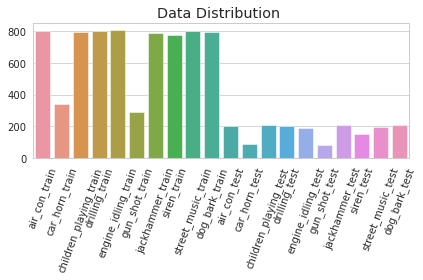

In [5]:
def visualize_holdout_balance(y_train, y_test):
    sns.set_style('whitegrid')
    
    casos_treino=len(y_train) 
    air_con_train=np.count_nonzero(y_train == 'air_conditioner')
    car_horn_train = np.count_nonzero(y_train == 'car_horn')
    children_playing_train = np.count_nonzero(y_train == 'children_playing')
    dog_bark_train= np.count_nonzero(y_train == 'dog_bark')
    drilling_train= np.count_nonzero(y_train == 'drilling')
    engine_idling_train= np.count_nonzero(y_train == 'engine_idling')
    gun_shot_train= np.count_nonzero(y_train == 'gun_shot')
    jackhammer_train= np.count_nonzero(y_train == 'jackhammer')
    siren_train= np.count_nonzero(y_train == 'siren')
    street_music_train= np.count_nonzero(y_train == 'street_music')
    print("casos_treino:",casos_treino)
    print("air_con_train: ", air_con_train)
    print("car_horn_train: ", car_horn_train)
    print("children_playing_train: ", children_playing_train)
    print("drilling_train: ", drilling_train)
    print("engine_idling_train: ", engine_idling_train)
    print("gun_shot_train: ", gun_shot_train)
    print("jackhammer_train: ", jackhammer_train)
    print("siren_train: ", siren_train)
    print("street_music_train: ", street_music_train)
    print("dog_bark_train: ", dog_bark_train)

    
    casos_test=len(y_test)
    air_con_test=np.count_nonzero(y_test == 'air_conditioner')
    car_horn_test = np.count_nonzero(y_test == 'car_horn')
    children_playing_test = np.count_nonzero(y_test == 'children_playing')
    dog_bark_test= np.count_nonzero(y_test == 'dog_bark')
    drilling_test= np.count_nonzero(y_test == 'drilling')
    engine_idling_test= np.count_nonzero(y_test == 'engine_idling')
    gun_shot_test= np.count_nonzero(y_test == 'gun_shot')
    jackhammer_test= np.count_nonzero(y_test == 'jackhammer')
    siren_test= np.count_nonzero(y_test == 'siren')
    street_music_test= np.count_nonzero(y_test == 'street_music')
    
    print("casos_teste:",casos_test)
    
    print("air_con_test: ", air_con_test)
    print("car_horn_test: ", car_horn_test)
    print("children_playing_test: ", children_playing_test)
    print("drilling_test: ", drilling_test)
    print("engine_idling_test: ", engine_idling_test)
    print("gun_shot_test: ", gun_shot_test)
    print("jackhammer_test: ", jackhammer_test)
    print("siren_test: ", siren_test)
    print("street_music_test: ", street_music_test)
    print("dog_bark_test: ", dog_bark_test)


    grafico=sns.barplot(x=['air_con_train','car_horn_train', 'children_playing_train', 'drilling_train', 
                           'engine_idling_train', 'gun_shot_train', 'jackhammer_train', 'siren_train', 
                           'street_music_train', 'dog_bark_train', 'air_con_test','car_horn_test', 'children_playing_test',
                          'drilling_test', 'engine_idling_test', 'gun_shot_test', 'jackhammer_test', 'siren_test', 
                          'street_music_test', 'dog_bark_test'],
                        y=[air_con_train,car_horn_train, children_playing_train, drilling_train, engine_idling_train, 
                           gun_shot_train, jackhammer_train, siren_train, street_music_train, dog_bark_train, 
                           air_con_test,car_horn_test, children_playing_test, drilling_test, engine_idling_test, 
                           gun_shot_test, jackhammer_test, siren_test, street_music_test, dog_bark_test])
    grafico.set_title('Data Distribution ')
    plt.xticks(rotation=70)
    plt.tight_layout()
    #plt.savefig('data_distribution_MLP.png')
    plt.show() 
    

visualize_holdout_balance(y_train, y_test)

In [6]:
lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_train.shape)
print(y_test.shape)

(6985, 10)
(1747, 10)


In [7]:
# neural network dimensions
n_dim = x_train.shape[1]
n_classes = y_train.shape[1]
print ("Features:", n_dim, "Classes:", n_classes)

Features: 193 Classes: 10


In [8]:
def definetrainfunctions(op):
    if op == "Adam":
        function_optmizer = optimizers.Adam(lr=LEARNING_RATE, decay=DECAY_RATE)
    elif op == "SGD":
        function_optmizer = optimizers.SGD(lr=LEARNING_RATE, decay=DECAY_RATE, momentum=MOMENT)
    print("Optimizer: " + str(function_optmizer))
    return function_optmizer

In [9]:
tf.random.set_seed(0)
np.random.seed(0)

function_optmizer=definetrainfunctions("Adam")

def create_model():
    model = Sequential()
    # layer 1
    model.add(Dense(n_dim, input_dim=n_dim, activation=ACTIVATION_FUNCTION))
    # layer 2
    model.add(Dense(600, activation=ACTIVATION_FUNCTION))
    model.add(Dropout(DROPOUT))
    # layer 3
    model.add(Dense(300, activation=ACTIVATION_FUNCTION))
    model.add(Dropout(DROPOUT))
    # layer 3
    model.add(Dense(100, activation=ACTIVATION_FUNCTION))
    model.add(Dropout(DROPOUT))
    # output layer
    model.add(Dense(n_classes, activation='softmax'))

    return model

Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fb79a435290>


In [10]:
model = create_model()

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 193)               37442     
_________________________________________________________________
dense_1 (Dense)              (None, 600)               116400    
_________________________________________________________________
dropout (Dropout)            (None, 600)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               180300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0

In [12]:
model.compile(loss='categorical_crossentropy', optimizer=function_optmizer, metrics=['accuracy'])

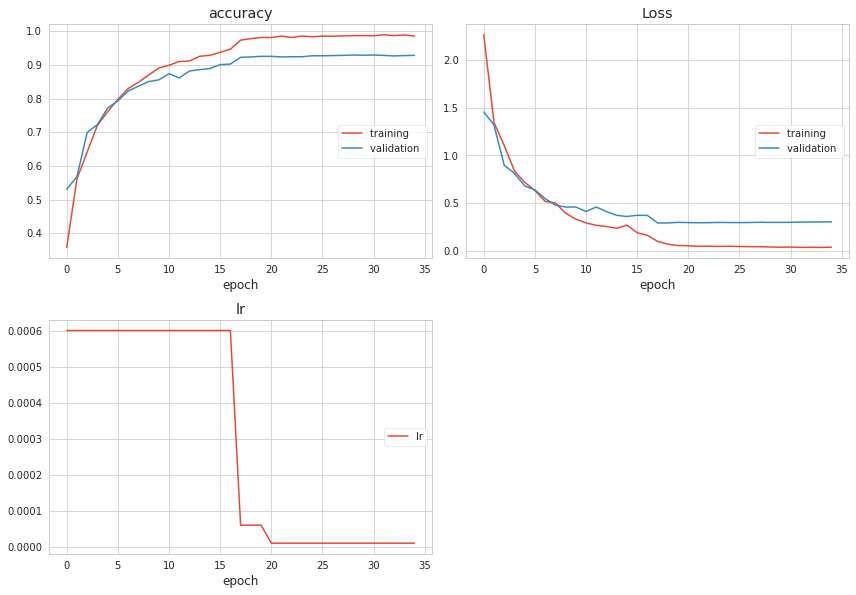

accuracy
	training         	 (min:    0.358, max:    0.990, cur:    0.986)
	validation       	 (min:    0.531, max:    0.930, cur:    0.928)
Loss
	training         	 (min:    0.039, max:    2.261, cur:    0.042)
	validation       	 (min:    0.294, max:    1.455, cur:    0.306)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
292/292 [==============================] - 9s 32ms/step - loss: 0.0422 - accuracy: 0.9858 - val_loss: 0.3056 - val_accuracy: 0.9284 - lr: 1.0000e-05
Scores:  [0.30564892292022705, 0.9284487962722778]
Erro modelo: 7.16%


In [13]:
m1 = ModelCheckpoint('best_MLP_model'+ ".h5", monitor='val_loss', verbose=0,
                         save_best_only=True, save_weights_only=False, mode='auto', period=1)
m4 = ModelCheckpoint('best_MLP_model_weights'+ ".hdf5", monitor='val_loss', verbose=0,
                         save_best_only=True, save_weights_only=True, mode='auto', period=1)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=2,cooldown=2,min_lr=0.00001,verbose=1)


history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[m1, reduce_learning_rate,PlotLossesCallback()])

# Avaliação final com os casos de teste
scores = model.evaluate(x_test, y_test, verbose=0)
print('Scores: ', scores)
print("Erro modelo: %.2f%%" % (100-scores[1]*100))

In [14]:
# obtain the prediction probabilities
y_prob = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test, 1)

Sensitivity:               98.72%
Specificity:               100.00%
Positive predictive value: 100.00%
Negative predictive value: 99.50%


Text(0.5, 51.0, 'Predicted label')

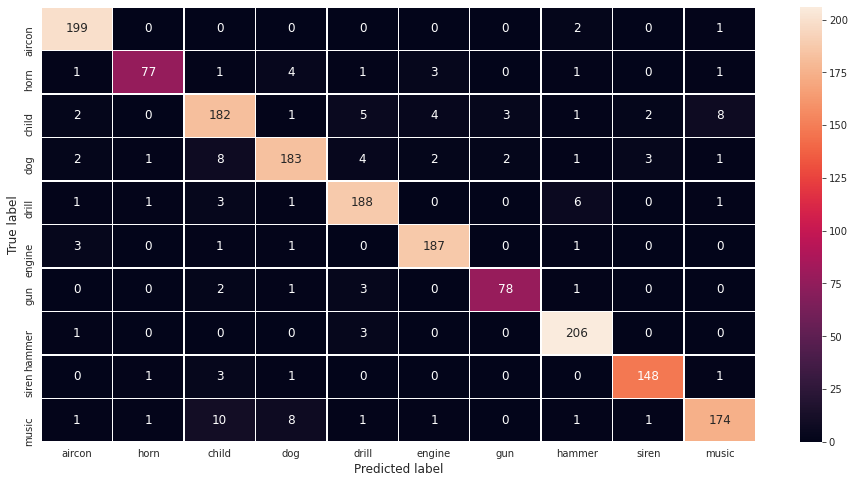

In [15]:
cm = confusion_matrix(y_true, y_pred)
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TP = cm[1,1]
sensitivity = (TP/(TP + FN))*100
specificity = (TN/(TN + FP))*100
PPV = (TP/(TP + FP))*100
NPV = (TN/(TN + FN))*100
print(f'Sensitivity:              {sensitivity: .2f}%')
print(f'Specificity:              {specificity: .2f}%')
print(f'Positive predictive value:{PPV: .2f}%')
print(f'Negative predictive value:{NPV: .2f}%')
plt.figure(figsize = (16,8))
sns.heatmap(cm,annot=True,xticklabels=LABELS,yticklabels=LABELS, annot_kws={"size": 12}, fmt='g', linewidths=.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [16]:
def predict_sound(sound_file_path):
    predict_file = sound_file_path
    predict_x = extract_features(predict_file)

    prediction = model.predict(predict_x)

    ind = np.argpartition(prediction[0], -2)[-2:]
    ind[np.argsort(prediction[0][ind])]
    ind = ind[::-1]

    print ("Top guess: ", SOUND_NAMES[ind[0]], " (",round(prediction[0,ind[0]],3),")")
    print ("2nd guess: ", SOUND_NAMES[ind[1]], " (",round(prediction[0,ind[1]],3),")")
    
def extract_features(filename):
    features = np.empty((0,193))
    X, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    features = np.vstack([features,ext_features])
    return features

for s in range(len(SOUND_NAMES)):

    print ("\n----- ", SOUND_NAMES[s], "-----")
    # load audio file and extract features
    predict_file = PARENT_DIR + SOUND_FILE_PATHS[s]
    predict_x = extract_features(predict_file)
    
    # generate prediction, passing in just a single row of features
    predictions = model.predict(predict_x)
    
    if len(predictions) == 0: 
        print ("No prediction")
        continue
    
 
    # get the indices of the top 2 predictions, invert into descending order
    ind = np.argpartition(predictions[0], -2)[-2:]
    ind[np.argsort(predictions[0][ind])]
    ind = ind[::-1]
    
    print ("Top guess: ", SOUND_NAMES[ind[0]], " (",round(predictions[0,ind[0]],3),")")
    print ("2nd guess: ", SOUND_NAMES[ind[1]], " (",round(predictions[0,ind[1]],3),")")


-----  air conditioner -----
Top guess:  air conditioner  ( 0.998 )
2nd guess:  children playing  ( 0.001 )

-----  car horn -----
Top guess:  car horn  ( 1.0 )
2nd guess:  street music  ( 0.0 )

-----  children playing -----
Top guess:  street music  ( 0.995 )
2nd guess:  children playing  ( 0.004 )

-----  dog bark -----
Top guess:  dog bark  ( 1.0 )
2nd guess:  car horn  ( 0.0 )

-----  drilling -----
Top guess:  drilling  ( 1.0 )
2nd guess:  jackhammer  ( 0.0 )

-----  engine idling -----
Top guess:  engine idling  ( 1.0 )
2nd guess:  street music  ( 0.0 )

-----  gun shot -----
Top guess:  gun shot  ( 1.0 )
2nd guess:  dog bark  ( 0.0 )

-----  jackhammer -----
Top guess:  drilling  ( 1.0 )
2nd guess:  street music  ( 0.0 )

-----  siren -----
Top guess:  siren  ( 1.0 )
2nd guess:  dog bark  ( 0.0 )

-----  street music -----
Top guess:  street music  ( 1.0 )
2nd guess:  air conditioner  ( 0.0 )


In [17]:
predict_sound('soundSamples/kids.wav')

Top guess:  children playing  ( 0.803 )
2nd guess:  street music  ( 0.176 )


In [18]:
predict_sound('soundSamples/aircond.wav')

Top guess:  street music  ( 0.983 )
2nd guess:  gun shot  ( 0.01 )


In [19]:
predict_sound('soundSamples/music.wav')

Top guess:  street music  ( 1.0 )
2nd guess:  dog bark  ( 0.0 )


In [20]:
predict_sound('soundSamples/traffic.wav')

Top guess:  street music  ( 0.945 )
2nd guess:  drilling  ( 0.053 )


In [21]:
predict_sound('soundSamples/jackhammer.wav')

Top guess:  street music  ( 0.914 )
2nd guess:  drilling  ( 0.045 )


In [22]:
predict_sound('soundSamples/gun.wav')

Top guess:  gun shot  ( 1.0 )
2nd guess:  dog bark  ( 0.0 )


In [23]:
predict_sound('soundSamples/car.wav')

Top guess:  children playing  ( 0.86 )
2nd guess:  dog bark  ( 0.061 )


In [31]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

In [32]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return indices

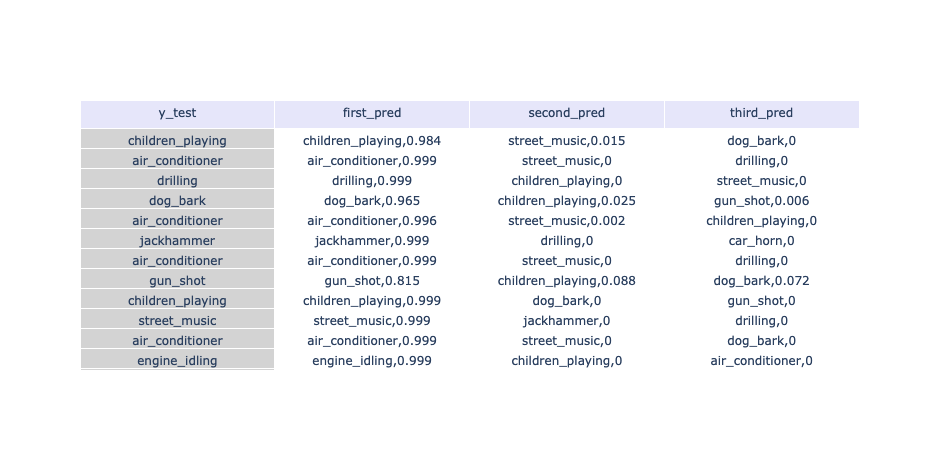

In [34]:
def print_series_prediction(sound, label):
    sounds = []
    first_preds = []
    first_percent = []
    second_preds = []
    second_percent = []
    third_preds = []
    third_percent = []
    for i in range(len(sound)): #para imprimir tabela de previsoes
        predictions = model.predict(sound)
        predic = largest_indices(predictions[i], 3)
        percentage = predictions[i][predic]
        sounds.append(label[i])
        
        first_preds.append((lb.inverse_transform(predic)[0], truncate(percentage[0],3)))
        second_preds.append((lb.inverse_transform(predic)[1], truncate(percentage[1],3)))
        third_preds.append((lb.inverse_transform(predic)[2], truncate(percentage[2],3)))
       
    data = {'y_test':  sounds,
            'first_pred': first_preds,
            'second_pred': second_preds,
            'third_pred': third_preds
           }
    df = pd.DataFrame(data)
    fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='lavender',
                align='center'),
    cells=dict(values=[df.y_test, df.first_pred,df.second_pred, df.third_pred],
               #fill_color='lightgrey',
               fill=dict(color=['lightgrey', 'white']),
               align='center'))])

    fig.show()


y_teste = np.argmax(y_test, axis= 1)
#print(y_teste)
print_series_prediction(x_test, lb.inverse_transform(y_teste))